Reference https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object
- quais as 10 hashtags que foram mais publicadas dentro de uma hora qualquer durante o período da coleta? Isto é, para cada hora, do minuto 00 até o minuto 59, conte quantas vezes cada hashtag aparece. Ao final, identifique quais as 10 hashtags diferentes, o dia/hora em que cada uma foi mais frequente e quantas vezes ela apareceu naquela hora.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import FloatType

import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.appName('pratical_work').getOrCreate()

In [3]:
data = spark.read.parquet("hdfs:///user/ghra2016/cleaned_data")

In [4]:
data.printSchema()

root
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- id_str: string (nullable = true)
 |-- text: string (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- text: string (nullable = true)
 |-- created_at: string (nullable = true)



In [5]:
data.show(1)

+-----------+------------------+--------------------+--------+-------------+
|coordinates|            id_str|                text|hashtags|   created_at|
+-----------+------------------+--------------------+--------+-------------+
|       null|721527751338024960|To morrendo de so...|      []|1460860595000|
+-----------+------------------+--------------------+--------+-------------+
only showing top 1 row



In [6]:
get_tags = F.udf(lambda tags: [item[1] for item in tags])
get_x = F.udf(lambda item: item[0][0])
get_y = F.udf(lambda item: item[0][1])

In [7]:
w_coordinates = data.where(F.col("coordinates").isNotNull())

In [8]:
w_coordinates = w_coordinates.withColumn("hashtags", get_tags(w_coordinates.hashtags))

In [9]:
w_coordinates = w_coordinates.withColumn("x", get_x(w_coordinates.coordinates).cast(FloatType()))
w_coordinates = w_coordinates.withColumn("y", get_y(w_coordinates.coordinates).cast(FloatType()))
w_coordinates = w_coordinates.drop("coordinates")

In [10]:
w_coordinates.show(1)

+------------------+--------------------+----------+-------------+--------+----------+
|            id_str|                text|  hashtags|   created_at|       x|         y|
+------------------+--------------------+----------+-------------+--------+----------+
|721527270767202304|Warung Day Festiv...|[elekfans]|1460860481000|-49.2776|-25.384666|
+------------------+--------------------+----------+-------------+--------+----------+
only showing top 1 row



In [20]:
clustering_input = w_coordinates.select(["x", "y"])

In [21]:
assembler = VectorAssembler(inputCols=["x", "y"], outputCol='features')
clustering_input = assembler.transform(clustering_input)

In [22]:
SEED = 1
k_list = range(3, 30)
distances = []
sillhouettes = []
for k in k_list:
    kmeans = KMeans().setK(k).setSeed(SEED)
    model = kmeans.fit(clustering_input)
    predictions = model.transform(clustering_input)
    
    total_dist = model.computeCost(clustering_input)
    evaluator = ClusteringEvaluator()
    
    distances.append(total_dist)
    sillhouettes.append(evaluator.evaluate(predictions))

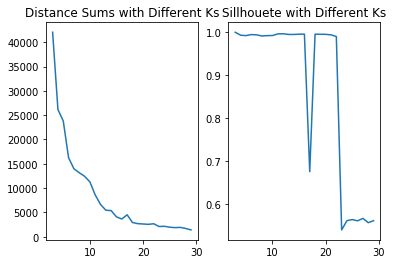

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2)

# ax1.plot([str(label) for label in k_list], distances)
ax1.plot(k_list, distances)
ax1.set_title("Distance Sums with Different Ks")

# ax2.plot([str(label) for label in k_list], sillhouettes)
ax2.plot(k_list, sillhouettes)
ax2.set_title("Sillhouete with Different Ks")

plt.show()

In [ ]:
# centroids = model.clusterCenters()

In [11]:
from datetime import datetime

data.withColumn("x", F.to_timestamp(data.created_at)).show(1)

+-----------+------------------+--------------------+--------+-------------+----+
|coordinates|            id_str|                text|hashtags|   created_at|   x|
+-----------+------------------+--------------------+--------+-------------+----+
|       null|721527751338024960|To morrendo de so...|      []|1460860595000|null|
+-----------+------------------+--------------------+--------+-------------+----+
only showing top 1 row



In [12]:
data.show(1)

+-----------+------------------+--------------------+--------+-------------+
|coordinates|            id_str|                text|hashtags|   created_at|
+-----------+------------------+--------------------+--------+-------------+
|       null|721527751338024960|To morrendo de so...|      []|1460860595000|
+-----------+------------------+--------------------+--------+-------------+
only showing top 1 row



In [13]:
from pyspark.sql.types import LongType, DateType
data = data.withColumn("created_at", F.udf(lambda s: s[:-3])(data.created_at))

In [14]:
data.show(1)

+-----------+------------------+--------------------+--------+----------+
|coordinates|            id_str|                text|hashtags|created_at|
+-----------+------------------+--------------------+--------+----------+
|       null|721527751338024960|To morrendo de so...|      []|1460860595|
+-----------+------------------+--------------------+--------+----------+
only showing top 1 row



In [16]:
data.show(1)

+-----------+------------------+--------------------+--------+----------+
|coordinates|            id_str|                text|hashtags|created_at|
+-----------+------------------+--------------------+--------+----------+
|       null|721527751338024960|To morrendo de so...|      []|1460860595|
+-----------+------------------+--------------------+--------+----------+
only showing top 1 row



In [21]:
data.withColumn("created_at", F.to_timestamp(data.created_at, 'yyyy-MM-dd HH:mm:ss').alias('dt')).show(1)

+-----------+------------------+--------------------+--------+----------+
|coordinates|            id_str|                text|hashtags|created_at|
+-----------+------------------+--------------------+--------+----------+
|       null|721527751338024960|To morrendo de so...|      []|      null|
+-----------+------------------+--------------------+--------+----------+
only showing top 1 row



In [19]:
data.where(F.col("coordinates").isNotNull()).count() / data.count()

0.06808391061080397